# Simulation for ML-RF

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

## RFF

In [2]:
def sample_1d(pdf, gamma):
    if pdf=='G':
        w=torch.randn(1)*gamma
        return w
    elif pdf=='L':
        w=torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    elif pdf=='C':
        w=torch.distributions.cauchy.Cauchy(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    
def sample(pdf, gamma, d):
    return torch.tensor([sample_1d(pdf, gamma) for _ in range(d)])

class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : shape (D,d)
    b : shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = torch.rand(self.D)*2*torch.pi
        self.W = sample(self.kernel, self.gamma, self.d*self.D).reshape(self.D,self.d)

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : (shape=(n,d))
            to transform; must be single dimension vector
        Returns
        -------
        x : (shape=(n,D))
            Feature space transformation of x
        """
        #print(self.W.shape,self.b.reshape(-1,1).shape,x.shape)
        #print((self.W @ x.T).shape)
       
        result=torch.sqrt(torch.tensor([2.0/self.D])) * torch.cos( self.W @ x.T  + (self.b.reshape(-1,1) @ torch.ones(len(x)).reshape(1,-1))) 
        #print(result.T.shape)
        return result.T

## Problem setup

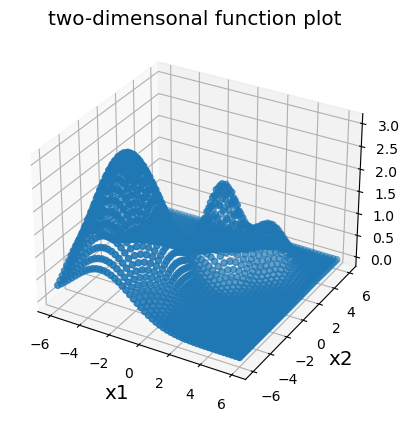

In [3]:
# binary Gaussian
def Gaussian(x, y, x0, y0, sigma):
    return np.exp(-((x - x0)**2 + (y - y0)**2) / (2.0 * sigma**2))

# parameter
x, y = np.meshgrid(np.linspace(-6, 6), np.linspace(-6, 6))

# calcalation
z = 3*Gaussian(x, y, -3, -3, 2)+2*Gaussian(x, y, 1, 1, 1)+Gaussian(x,y,3,3,1)

# 3D plot
ax=plt.axes(projection="3d")
ax.scatter(x,y,z)
plt.title("two-dimensonal function plot",fontsize="x-large")
plt.xlabel('x1',fontsize="x-large")
plt.ylabel('x2',fontsize="x-large")
plt.show()

data generation

In [4]:
np.random.seed(0)
data=12*np.random.rand(5000,2)-6
noise=0.01*np.random.randn(5000)
x=data.T[0]
y=data.T[1]
z = 3*Gaussian(x, y, -3, -3, 2)+2*Gaussian(x, y, 1, 1, 1)+Gaussian(x,y,3,3,1)+noise

In [5]:
train_x=data
train_y=z
nntrain_x = torch.from_numpy(train_x).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y).float()) 

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len

## DNN

In [6]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.1,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=8e-4,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)
dnn_trainloss=[]
dnn_testloss=[]
t0=time.time()
for epoch in range(1000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()

    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            ''')
    
    dnn_trainloss.append(float(train_loss))
            
dnn_fit = time.time() - t0
print("DNN complexity and model fitted in %.3f s" % dnn_fit)

Net(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)


epoch 0
            Train set - loss: 0.4997231364250183
            
epoch 100
            Train set - loss: 0.10474160313606262
            
epoch 200
            Train set - loss: 0.02720792219042778
            
epoch 300
            Train set - loss: 0.004527010954916477
            
epoch 400
            Train set - loss: 0.004751539323478937
            
epoch 500
            Train set - loss: 0.0037609590217471123
            
epoch 600
            Train set - loss: 0.0035286755301058292
            
epoch 700
            Train set - loss: 0.0035823765210807323
            
epoch 800
            Train set - loss: 0.001957970904186368
            
epoch 900
            Train set - loss: 0.003363223746418953
            
DNN complexity and model fitted in 164.831 s


In [7]:
dnn_x0=torch.from_numpy(train_x[:]).float()
with torch.no_grad():
    dnn_x0 = dnn_x0.to(device)
    dnn_pred = net(dnn_x0)
    print(np.array(dnn_pred).reshape(-1))

[0.6863722  1.615499   0.3559559  ... 0.5124652  0.06629363 0.0205223 ]


# MLK

In [26]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)

rff1=RandomFourierFeature(2,32,kernel='G',gamma=1)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=2)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(32, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        x = rff2.transform(x)
        return self.fc2(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.5,b=-0.5)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=8e-4,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)

loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]
t0 = time.time()
for epoch in range(1000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    if epoch % 100 == 0:         
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            ''')
   
    kernelnn_trainloss.append(float(train_loss))
        
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (fc1): Linear(in_features=32, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 0.6619552373886108
            
epoch 100
            Train set - loss: 0.017792824655771255
            
epoch 200
            Train set - loss: 0.00789447408169508
            
epoch 300
            Train set - loss: 0.0024867570027709007
            
epoch 400
            Train set - loss: 0.002706632949411869
            
epoch 500
            Train set - loss: 0.0029743078630417585
            
epoch 600
            Train set - loss: 0.0014673604164272547
            
epoch 700
            Train set - loss: 0.001878521405160427
            
epoch 800
            Train set - loss: 0.002211459679529071
            
epoch 900
            Train set - loss: 0.0017253411933779716
            
KernelNet complexity and model fitted in 127.131 s


In [27]:
kernel_x0=torch.from_numpy(train_x[:]).float()
with torch.no_grad():
    kernel_x0 = kernel_x0.to(device)
    kernel_pred = net(kernel_x0)
    print(np.array(kernel_pred).reshape(-1))

[0.5869285  1.6911025  0.36275896 ... 0.46205926 0.0625968  0.01924974]


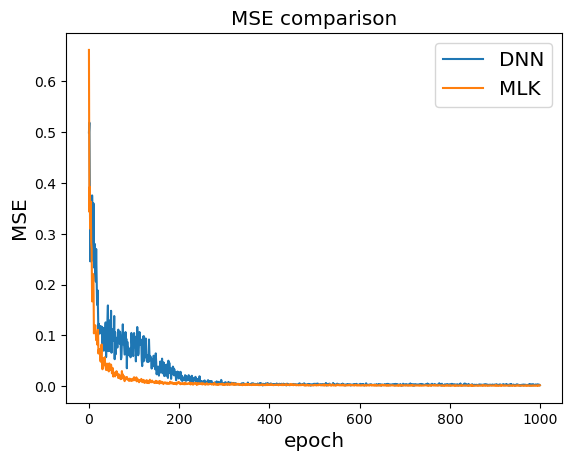

In [28]:
plt.plot(dnn_trainloss)
plt.plot(kernelnn_trainloss)
plt.legend(["DNN","MLK"],fontsize="x-large")
plt.xlabel("epoch",fontsize="x-large")
plt.ylabel("MSE",fontsize="x-large")
plt.title("MSE comparison",fontsize="x-large")
plt.show()

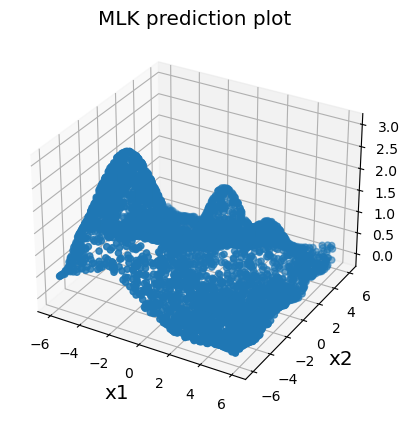

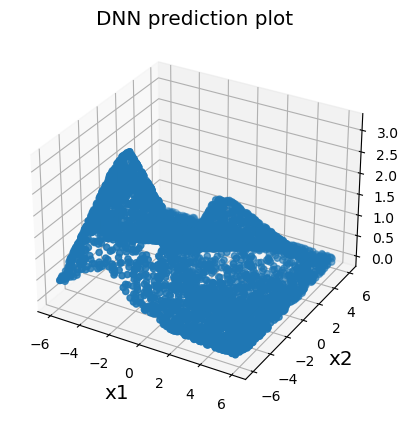

In [33]:
# 3D plot
ax=plt.axes(projection="3d")
ax.scatter(data.T[0],data.T[1],kernel_pred)
plt.title("MLK prediction plot",fontsize="x-large")
plt.xlabel('x1',fontsize="x-large")
plt.ylabel('x2',fontsize="x-large")
plt.show()
# 3D plot
ax=plt.axes(projection="3d")
ax.scatter(data.T[0],data.T[1],dnn_pred)
plt.title("DNN prediction plot",fontsize="x-large")
plt.xlabel('x1',fontsize="x-large")
plt.ylabel('x2',fontsize="x-large")
plt.show()

## Resnet

In [12]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(infeatures,outfeatures)
    
    def forward(self, x):
        y = self.fc1(x)
        y= F.relu(y)
        x = self.fc2(x)
        return F.relu(x+y)


class ResNet(nn.Module): 
    def __init__(self):
        super(ResNet, self).__init__()
        self.rblock1 = ResidualBlock(2,32)
        self.rblock2 = ResidualBlock(32,8)
        self.fc3 = nn.Linear(8,1)
    
 
    def forward(self, x):
        x = self.rblock1(x)
        x = self.rblock2(x)
        return self.fc3(x)
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.1,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResNet()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=5e-4,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)
res_trainloss=[]
res_testloss=[]
t0=time.time()
for epoch in range(1000):
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            ''')
    
    res_trainloss.append(float(train_loss))
            
dnn_fit = time.time() - t0
print("ResNet complexity and model fitted in %.3f s" % dnn_fit)

ResNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=2, out_features=32, bias=True)
    (fc2): Linear(in_features=2, out_features=32, bias=True)
  )
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=32, out_features=8, bias=True)
    (fc2): Linear(in_features=32, out_features=8, bias=True)
  )
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 0.6018610596656799
            
epoch 100
            Train set - loss: 0.10793759673833847
            
epoch 200
            Train set - loss: 0.018201379105448723
            
epoch 300
            Train set - loss: 0.004536731168627739
            
epoch 400
            Train set - loss: 0.0033124135807156563
            
epoch 500
            Train set - loss: 0.0020041840616613626
            
epoch 600
            Train set - loss: 0.0034305911976844072
            
epoch 700
            Train set - loss: 0.0014719574246555567
            
epoch 800
            Train set -

In [13]:
res_x0=torch.from_numpy(train_x[:]).float()
with torch.no_grad():
    res_x0 = res_x0.to(device)
    res_pred = net(res_x0)
    print(np.array(res_pred).reshape(-1))

[0.6617484  1.7533383  0.35346764 ... 0.4216382  0.0333156  0.0143103 ]


## RK

In [14]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)

rff0=RandomFourierFeature(2,32,kernel='G',gamma=1)
rff1=RandomFourierFeature(8,8,kernel='G',gamma=2)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,rff):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.rff=rff
        
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=self.rff
        x = self.fc1(x)
        y = rff.transform(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(32,8,rff1)
        self.fc2 =nn.Linear(8,1)
 
    def forward(self, x):
        x = rff0.transform(x)
        x = self.rblock1(x)
        return self.fc2(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.5,b=0.5)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResKernelNet()
net = net.to(device)
torch.manual_seed(1)
#net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=5e-4,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)

loss=[]
reskernel_trainloss=[]
reskernel_testloss=[]
t0 = time.time()
for epoch in range(1000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    if epoch % 100 == 0:         
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            ''')
    reskernel_trainloss.append(float(train_loss))
        
    
dnn_fit = time.time() - t0
print("Residual KernelNet complexity and model fitted in %.3f s" % dnn_fit)

ResKernelNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=32, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
  )
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 0.5367237329483032
            
epoch 100
            Train set - loss: 0.014915641397237778
            
epoch 200
            Train set - loss: 0.007690312806516886
            
epoch 300
            Train set - loss: 0.0037788194604218006
            
epoch 400
            Train set - loss: 0.0026230609510093927
            
epoch 500
            Train set - loss: 0.002173665212467313
            
epoch 600
            Train set - loss: 0.003284639213234186
            
epoch 700
            Train set - loss: 0.0016995507758110762
            
epoch 800
            Train set - loss: 0.0011118253460153937
            
epoch 900
            Train set - loss: 0.001280065975151956
            
Residual KernelNet complexity and

In [15]:
rk_x0=torch.from_numpy(train_x[:]).float()
with torch.no_grad():
    rk_x0 = rk_x0.to(device)
    rk_pred = net(rk_x0)
    print(np.array(rk_pred).reshape(-1))

[ 0.6209684   1.7573223   0.3360714  ...  0.4073616   0.06360874
 -0.01547706]


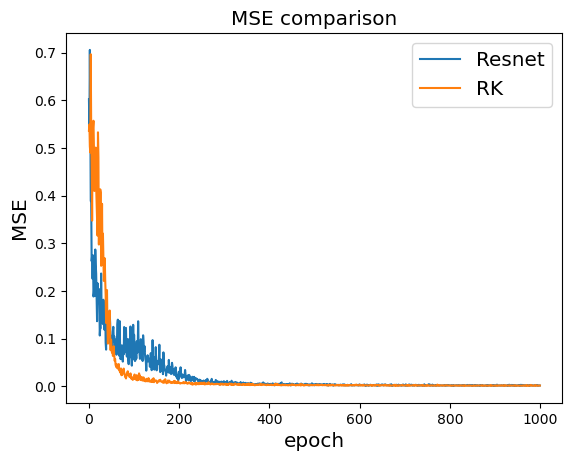

In [16]:
plt.plot(res_trainloss)
plt.plot(reskernel_trainloss)
plt.legend(["Resnet","RK"],fontsize="x-large")
plt.xlabel("epoch",fontsize="x-large")
plt.ylabel("MSE",fontsize="x-large")
plt.title("MSE comparison",fontsize="x-large")
plt.show()

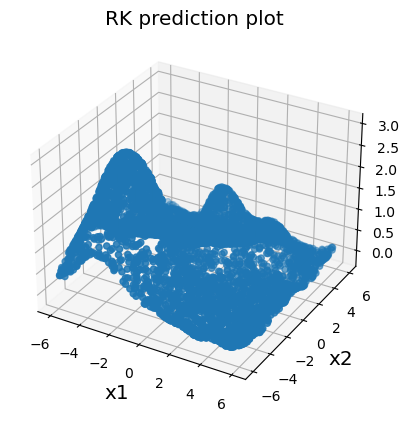

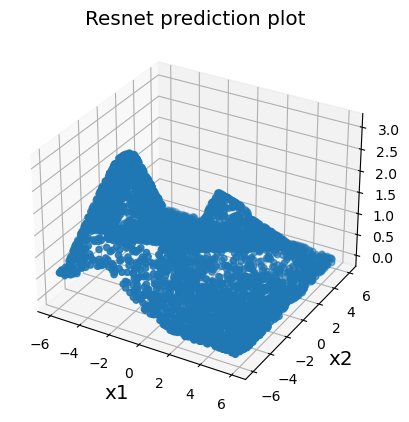

In [32]:
# 3D plot
ax=plt.axes(projection="3d")
ax.scatter(data.T[0],data.T[1],rk_pred)
plt.title("RK prediction plot",fontsize="x-large")
plt.xlabel('x1',fontsize="x-large")
plt.ylabel('x2',fontsize="x-large")
plt.show()
# 3D plot
ax=plt.axes(projection="3d")
ax.scatter(data.T[0],data.T[1],res_pred)
plt.title("Resnet prediction plot",fontsize="x-large")
plt.xlabel('x1',fontsize="x-large")
plt.ylabel('x2',fontsize="x-large")
plt.show()

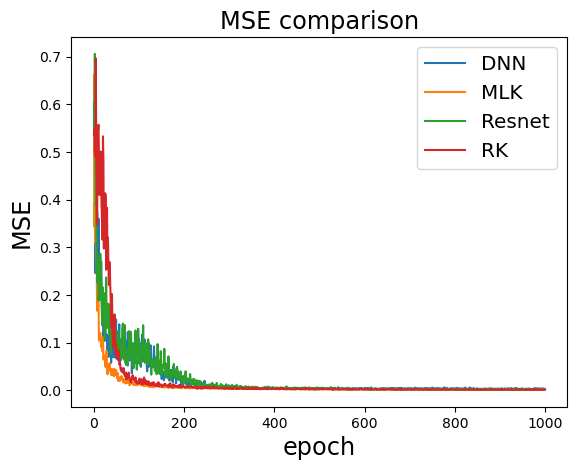

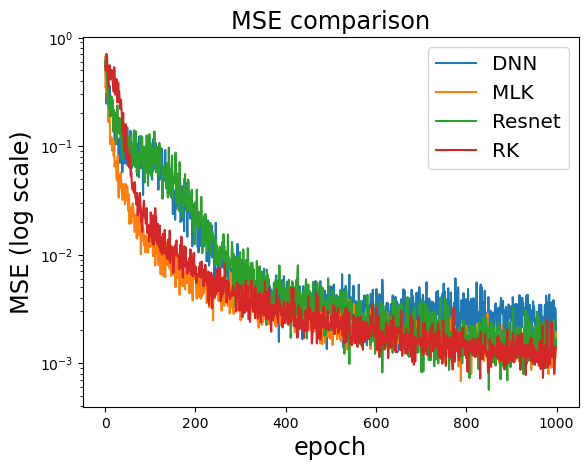

In [36]:
tt=0
plt.plot(np.arange(tt,1000),dnn_trainloss[tt:])
plt.plot(np.arange(tt,1000),kernelnn_trainloss[tt:])
plt.plot(np.arange(tt,1000),res_trainloss[tt:])
plt.plot(np.arange(tt,1000),reskernel_trainloss[tt:])
plt.legend(["DNN","MLK","Resnet","RK"],fontsize="x-large")
plt.xlabel("epoch",fontsize="xx-large")
plt.ylabel("MSE",fontsize="xx-large")
plt.title("MSE comparison",fontsize="xx-large")
plt.show()

plt.plot(dnn_trainloss)
plt.plot(kernelnn_trainloss)
plt.plot(res_trainloss)
plt.plot(reskernel_trainloss)
plt.legend(["DNN","MLK","Resnet","RK"],fontsize="x-large")
plt.xlabel("epoch",fontsize="xx-large")
plt.ylabel("MSE (log scale)",fontsize="xx-large")
plt.yscale("log")
plt.title("MSE comparison",fontsize="xx-large")
plt.show()